# **1. MNIST 데이터 이해하기**

MNIST는 숫자 0~9까지의 이미지로 구성된 손글씨 데이터셋입니다. 총 60,000개의 훈련 데이터와 레이블, 총 10,000개의 테스트 데이터와 레이블로 구성되어 있습니다. 레이블은 0부터 9까지 총 10개입니다. 

MNIST 문제는 손글씨로 적힌 숫자 이미지가 들어오면, 그 이미지가 무슨 숫자인지 맞추는 문제입니다. 각각 이미지는 아래와 같이 28 x 28픽셀의 이미지입니다.

<img src = "https://wikidocs.net/images/page/60324/mnist_SVbcYYG.png">

이 문제를 풀기 위해선 28 x 28 = 784 픽셀에 대해 총 784 개의 원소를 가진 벡터로 만들어 풀 수 있습니다. 이렇게 되면 총 784개의 특성을 가진 샘플이 됩니다. 

# **2. 토치비전**

torchvision은 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하는 패키지입니다. 아래의 링크에 어떤 데이터셋들과 모델들, 전처리 방법들을 제공하고 있는지 보여줍니다.

링크 : https://pytorch.org/docs/stable/torchvision/index.html

- 자연어 처리를 위해서는 torchtext라는 패키지가 있습니다.

# **3. 분류기 구현을 위한 사전 설정**

우선 필요한 도구들을 불러옵시다.

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

현재 환경에서 GPU 연산이 가능하면 GPU 연산을, 불가능하면 CPU 연산을 하도록 설정합니다.

In [2]:
# GPU를 사용가능하면 True, 불가하면 False를 리턴
USE_CUDA = torch.cuda.is_available()

# GPU 사용이 가능하면 사용하고 아니면 CPU 사용
device = torch.device("cuda" if USE_CUDA else "cpu")
print(f"{device} 기기로 학습합니다")

cpu 기기로 학습합니다


랜덤 시드를 고정합니다.

In [3]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

하이퍼파라미터를 변수로 둡니다.

In [4]:
# hyperparameters
training_epochs = 15
batch_size = 100

# **4. MNIST 분류기 구현하기**

torchvision.datasets.dsets.MNIST를 사용하여 MNIST 데이터셋을 불러올 수 있습니다.

In [5]:
# MNIST dataset
mnist_train = dsets.MNIST(
    root='MNIST_data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

mnist_test = dsets.MNIST(
    root='MNIST_data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

dsets.MNIST 인자 설명
- root: MNIST 데이터를 다운받을 경로 
- train: True -> MNIST 훈련 데이터 / False -> 테스트 데이터
- transform: 현재 데이터를 파이토치 텐서로 변환
- download: 해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다는 의미

이제 앞서 미니 배치와 데이터로드 챕터에서 학습했던 데이터로더를 사용합니다.

In [6]:
# dataset loader
data_loader = DataLoader(
    dataset=mnist_train,   # 불러올 대상
    batch_size=batch_size, # 배치 크기
    shuffle=True,          # 매 epoch마다 섞을 것인가
    drop_last=True,        # 마지막 배치를 버릴 것인가
    )

>drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.

이제 모델을 설계합니다. input_dim은 784이고 output_dim은 10입니다.

In [7]:
# MNIST data image of shape 28 x 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)

to() 함수는 연산을 어디서 수행할지 정합니다. 모델의 매개변수를 지정한 장치의 메모리로 보내는 것입니다. CPU를 사용할 경우에는 필요없지만 GPU를 사용하려면 to('cuda')를 해줘야 합니다. 아무것도 지정하지 않은 경우는 CPU 연산으로 보면 됩니다.

bias는 편향 b를 사용할 것인지를 나타냅니다. 기본값으로 True이므로 굳이 할 필요는 없으나 명시적으로 True를 해주었습니다.

이제 비용 함수와 옵티마이저를 정의합니다.

In [8]:
# cost function & optimizer
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수 포함
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

> 앞서 소프트맥스 회귀를 배울 때는 torch.nn.functional.cross_entropy()를 사용하였으나 여기서는 torch.nn.CrossEntropyLoss()을 사용하고 있습니다. 둘 다 파이토치에서 제공하는 크로스 엔트로피 함수로 둘 다 소프트맥스 함수를 포함하고 있습니다.

In [9]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)
    
    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수이다.
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
print("Learning finished")

Epoch: 0001 cost = 0.535150647
Epoch: 0002 cost = 0.359577745
Epoch: 0003 cost = 0.331264287
Epoch: 0004 cost = 0.316404700
Epoch: 0005 cost = 0.307107002
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956199
Epoch: 0009 cost = 0.287074089
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526889
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874794
Epoch: 0015 cost = 0.274422735
Learning finished


Accuracy: 0.8883000016212463
Label:  5
Prediction:  3


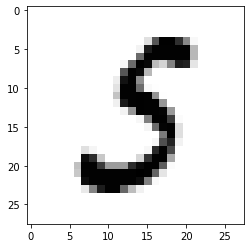

In [12]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print("Accuracy:", accuracy.item())
    
    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해봅니다.
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)
    
    print("Label: ", Y_single_data.item())
    single_prediction = linear(X_single_data)
    print("Prediction: ", torch.argmax(single_prediction, 1).item())
    
    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap="Greys", interpolation="nearest")
    plt.show()